In [1]:
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import scipy
%matplotlib inline
path = '/Users/chris/Desktop/mastrangelo/data/'
# all data downloaded from Berger et al 2020's ancillary tables: https://arxiv.org/src/2001.07737v3/anc
# the paper we're comparing against: https://arxiv.org/pdf/2005.14671.pdf
# command line edit to get rid of double backslashes at end of each row: sed -e "s/\\\//g" GKSPCPapTable2_Final.txt > GKSPCPapTable2_cleaned.txt
table2 = pd.read_csv(path+'GKSPCPapTable2_cleaned.txt', sep='&', header=0)
print(len(table2))
print(table2.head())
print(table2.columns)

186301
      KIC  iso_mass  iso_mass_err1  iso_mass_err2  iso_teff  iso_teff_err1   
0  757076     1.396          0.179         -0.218    5052.2          103.9  \
1  757099     0.873          0.054         -0.039    5364.9          102.7   
2  757137     1.669          0.309         -0.300    4628.7           84.8   
3  757280     1.715          0.086         -0.089    6856.8          144.4   
4  757450     0.914          0.062         -0.057    5301.2          111.0   

   iso_teff_err2  iso_logg  iso_logg_err1  iso_logg_err2  ...  iso_age   
0          -86.6     3.373          0.067         -0.081  ...     2.47  \
1          -84.9     4.318          0.037         -0.029  ...    15.20   
2          -76.2     2.388          0.083         -0.086  ...     1.51   
3         -139.9     3.834          0.033         -0.032  ...     1.24   
4         -103.1     4.432          0.045         -0.044  ...     9.46   

   unReAgeFlag  iso_age_err1  iso_age_err2  iso_dis  iso_dis_err1   
0         

In [2]:
import matplotlib.pylab as pylab
pylab_params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(pylab_params)


In [3]:
# remove stars with unreliable ages or bad goodness of fit
table2 = table2.loc[(table2.unReAgeFlag.isnull()) & (table2.iso_gof==1.)]
print(len(table2))

150560


In [4]:
# remove stars with uninformative posteriors (per paper, terminal age of main sequence > 20 Gyr)
table2 = table2.loc[table2['TAMS']<=20]
print(len(table2))
# nice to see that tracks with bad gof or unreliable age

150560


In [5]:
# remove stars beyond [3700, 7500] K Teff, ie. keep only FGK stars
fgk = table2.loc[(table2['iso_teff'] <= 7500) & (table2['iso_teff'] >= 3700)]
print(len(fgk))

147900


In [6]:
# introduce Table 1 to use RUWE (re-normalized unit-weight error), aka binary star/edge-of-parameter space classifier
# command line edit to get rid of double backslashes at end of each row: sed -e "s/\\\//g" GKSPCPapTable1_Final.txt > GKSPCPapTable1_cleaned.txt
table1 = pd.read_csv(path+'GKSPCPapTable1_cleaned.txt', sep='&', header=0)
table1 = table1.loc[table1.RUWE<=1.2]
print(len(table1))
print(table1.head())
print(table1.columns)

164740
      KIC     gmag  gmag_err    kmag  kmag_err  parallax  parallax_err    feh   
0  757076  12.3510    0.0203   9.559     0.017    1.5239        0.0483    NaN  \
2  757137  10.0523    0.0279   6.722     0.017    1.7534        0.0253    NaN   
3  757280  12.1329    0.0200  10.627     0.018    1.2137        0.0220    NaN   
4  757450  15.8950    0.0202  13.118     0.029    1.1989        0.0261  0.229   
7  892010  12.6168    0.0209   9.041     0.017    0.5414        0.0242    NaN   

   feh_err    RUWE  num_gaia_companions Kmag_final_prov evstate  
0      NaN  0.9467                    0             NaN     NaN  
2      NaN  0.9126                    0             NaN     RGB  
3      NaN  0.8704                    0             NaN     NaN  
4     0.15  1.0300                    0             NaN     NaN  
7      NaN  1.0141                    0             NaN     NaN  
Index(['KIC', 'gmag', 'gmag_err', 'kmag', 'kmag_err', 'parallax',
       'parallax_err', 'feh', 'feh_err', 'RU

In [7]:
# join tables
catalog = pd.merge(fgk, table1, how='inner', on='KIC')
print(catalog.head())
print(len(catalog))

      KIC  iso_mass  iso_mass_err1  iso_mass_err2  iso_teff  iso_teff_err1   
0  757076     1.396          0.179         -0.218    5052.2          103.9  \
1  757137     1.669          0.309         -0.300    4628.7           84.8   
2  757280     1.715          0.086         -0.089    6856.8          144.4   
3  757450     0.914          0.062         -0.057    5301.2          111.0   
4  892010     1.710          0.708         -0.402    4555.8          141.3   

   iso_teff_err2  iso_logg  iso_logg_err1  iso_logg_err2  ...    kmag   
0          -86.6     3.373          0.067         -0.081  ...   9.559  \
1          -76.2     2.388          0.083         -0.086  ...   6.722   
2         -139.9     3.834          0.033         -0.032  ...  10.627   
3         -103.1     4.432          0.045         -0.044  ...  13.118   
4          -92.4     2.299          0.163         -0.119  ...   9.041   

   kmag_err  parallax  parallax_err    feh  feh_err    RUWE   
0     0.017    1.5239        

In [8]:
# isolate giant stars
# using unnumbered equation in first paragraph of Sec 4.2.1 ("Sample Selection") in Berger et al 2020b 
catalog['logR'] = np.log10(catalog.iso_rad)
catalog['is_giant'] = np.where(catalog['logR'] >= 0.00035*(catalog['iso_teff'] - 4500) + 0.15, True, False)
catalog = catalog.loc[catalog['is_giant'] == False]
print(len(catalog))
print(catalog.head())

112397
      KIC  iso_mass  iso_mass_err1  iso_mass_err2  iso_teff  iso_teff_err1   
2  757280     1.715          0.086         -0.089    6856.8          144.4  \
3  757450     0.914          0.062         -0.057    5301.2          111.0   
6  892195     0.862          0.057         -0.040    5333.4          101.3   
7  892667     1.548          0.081         -0.087    6704.9          148.8   
8  892675     1.038          0.066         -0.076    5929.4          108.9   

   iso_teff_err2  iso_logg  iso_logg_err1  iso_logg_err2  ...  parallax   
2         -139.9     3.834          0.033         -0.032  ...    1.2137  \
3         -103.1     4.432          0.045         -0.044  ...    1.1989   
6          -84.2     4.372          0.039         -0.029  ...    2.0802   
7         -128.8     3.950          0.034         -0.036  ...    0.8512   
8         -108.1     4.385          0.035         -0.043  ...    1.7114   

   parallax_err    feh  feh_err    RUWE  num_gaia_companions  Kmag_final_

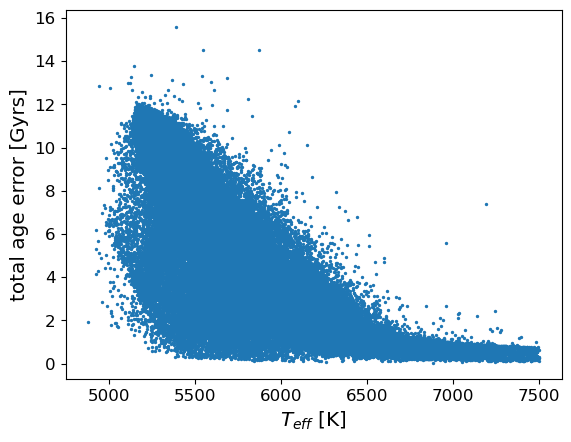

In [9]:
plt.scatter(catalog.iso_teff, np.abs(catalog.iso_age_err1)+np.abs(catalog.iso_age_err2), s=2)
plt.ylabel('total age error [Gyrs]')
plt.xlabel('$T_{eff}$ [K]')
plt.show()

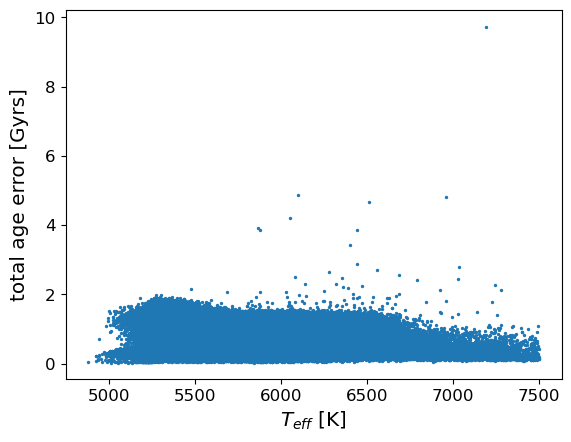

total:  67380
K dwarfs:  2873
percentage of K dwarfs in sample:  0.042638765212229146


In [10]:
# get rid of stars with fractional age errors greater than median age error [0.56 Gyrs]

catalog['fractional_err1'] = catalog.iso_age_err1/catalog.iso_age
catalog['fractional_err2'] = catalog.iso_age_err2/catalog.iso_age
plt.scatter(catalog.iso_teff, catalog.fractional_err1, s=2)
plt.ylabel('total age error [Gyrs]')
plt.xlabel('$T_{eff}$ [K]')
plt.show()

catalog = catalog.loc[catalog.fractional_err1 <= 0.56]
catalog = catalog.loc[np.abs(catalog.fractional_err2) <= 0.56]
print("total: ", len(catalog))
print("K dwarfs: ", len(catalog.loc[catalog.iso_teff < 5300])) # how many of these are K dwarfs?
print("percentage of K dwarfs in sample: ", len(catalog.loc[catalog.iso_teff < 5300])/len(catalog))

In [11]:
# young vs old fraction
print("stars younger than 1 Gyr: ", len(catalog.loc[catalog.iso_age <= 1]))
print("stars older than 1 Gyr: ", len(catalog.loc[catalog.iso_age > 1]))
print("percentage of sample younger than 1 Gyr: ", len(catalog.loc[catalog.iso_age <= 1])/len(catalog))
print("median age of sample: ", np.median(catalog.iso_age))

stars younger than 1 Gyr:  735
stars older than 1 Gyr:  66645
percentage of sample younger than 1 Gyr:  0.010908281389136243
median age of sample:  5.3


In [12]:
# catalog.to_csv('/Users/chris/Desktop/mastrangelo/data/berger_kepler_stellar_fgk.csv', index=False)


[   4   13   47  107  157  355  903 1264 1380 1479 1701 1929 2163 2549
 3124 3481 3842 4010 3938 3735 3568 3116 2893 2514 2418 1965 1752 1713
 1489 1325 1100  976  888  797  686  594  560  459  338  369  305  242
  223  183  183  130  136  110   92   75] [4879.6   4932.002 4984.404 5036.806 5089.208 5141.61  5194.012 5246.414
 5298.816 5351.218 5403.62  5456.022 5508.424 5560.826 5613.228 5665.63
 5718.032 5770.434 5822.836 5875.238 5927.64  5980.042 6032.444 6084.846
 6137.248 6189.65  6242.052 6294.454 6346.856 6399.258 6451.66  6504.062
 6556.464 6608.866 6661.268 6713.67  6766.072 6818.474 6870.876 6923.278
 6975.68  7028.082 7080.484 7132.886 7185.288 7237.69  7290.092 7342.494
 7394.896 7447.298 7499.7  ]


/var/folders/fm/fpkllzw93kq7c5y3zl98167m0000gn/T/ipykernel_2919/1760300831.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((2,1), (0,0))
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


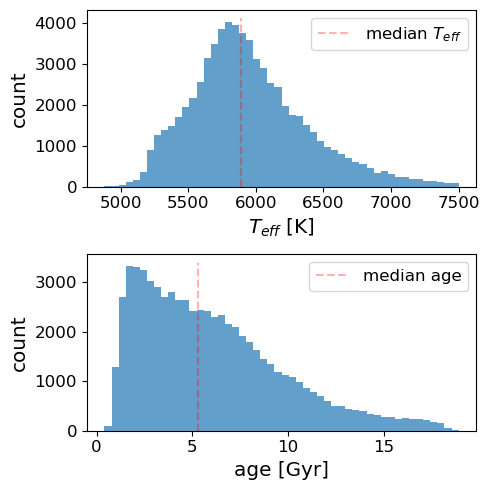

In [13]:
# teff histogram for all stars with well-constrained ages 
teff_hist, teff_bin_edges = np.histogram(catalog.iso_teff, bins=50)
print(teff_hist, teff_bin_edges)
#plt.bar(teff_bin_edges[:-1], teff_hist, width = 0.3)

fig, axes = plt.subplots(figsize=(5,5))
ax1 = plt.subplot2grid((2,1), (0,0))
ax1.hist(catalog.iso_teff, bins=50, alpha=0.7)
ax1.set_ylabel("count")
ax1.set_xlabel(r"$T_{eff}$ [K]")
# plot vertical red line through median Teff
ax1.plot([np.median(catalog.iso_teff), np.median(catalog.iso_teff)], 
         [0,4100], color='r', alpha=0.3, linestyle='--', label=r'median $T_{eff}$')
ax1.legend()

ax2 = plt.subplot2grid((2,1), (1,0))
ax2.hist(catalog.iso_age, bins=50, alpha=0.7)
# plot vertical red line through median age 
ax2.plot([np.median(catalog.iso_age), np.median(catalog.iso_age)], 
         [0,3400], color='r', alpha=0.3, linestyle='--', label='median age')
ax2.set_ylabel("count")
ax2.set_xlabel("age [Gyr]")
ax2.legend()
fig.tight_layout()
plt.savefig('/Users/chris/Desktop/mastrangelo/figures/sample_properties.eps', format='eps')

plt.show()

Are asymmetric errors close enough to being treatable as Gaussian-distributed?

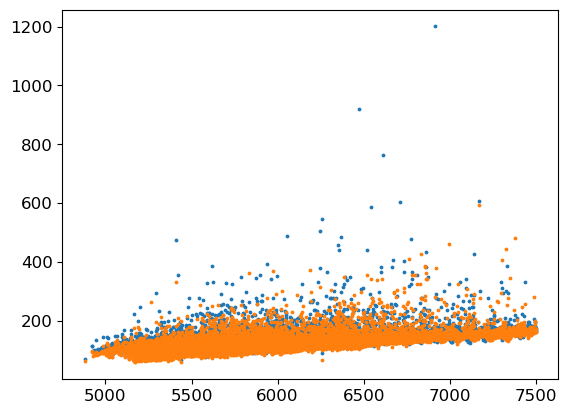

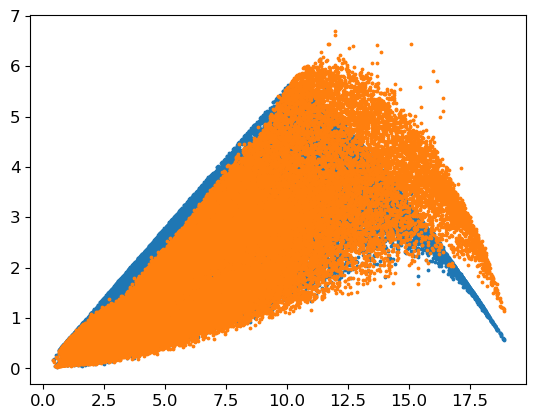

In [14]:
plt.scatter(catalog.iso_teff, catalog.iso_teff_err1, s=3)
plt.scatter(catalog.iso_teff, np.abs(catalog.iso_teff_err2), s=3)
plt.show()

plt.scatter(catalog.iso_age, catalog.iso_age_err1, s=3)
plt.scatter(catalog.iso_age, np.abs(catalog.iso_age_err2), s=3)
plt.show()

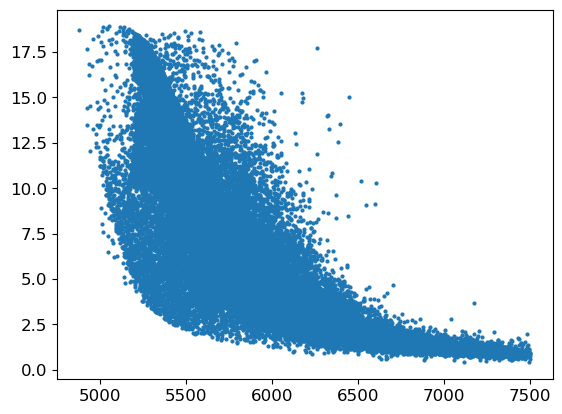

In [15]:
plt.scatter(catalog.iso_teff, catalog.iso_age, s=4)
plt.show()

I think we can get away with averaging the asymmetric errors and drawing them from a normal distribution.

In [16]:
catalog.iso_teff_err = 0.5 * (catalog.iso_teff_err1 + np.abs(catalog.iso_teff_err2))
catalog.iso_age_err = 0.5 * (catalog.iso_age_err1 + np.abs(catalog.iso_age_err2))

/var/folders/fm/fpkllzw93kq7c5y3zl98167m0000gn/T/ipykernel_2919/908293507.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  catalog.iso_teff_err = 0.5 * (catalog.iso_teff_err1 + np.abs(catalog.iso_teff_err2))
/var/folders/fm/fpkllzw93kq7c5y3zl98167m0000gn/T/ipykernel_2919/908293507.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  catalog.iso_age_err = 0.5 * (catalog.iso_age_err1 + np.abs(catalog.iso_age_err2))


Split sample into F, G, and K dwarfs, as well as young, middle-aged, and old stars.

In [17]:
fdwarfs = catalog.loc[(catalog.iso_teff < 7500) & (catalog.iso_teff > 6000)]
gdwarfs = catalog.loc[(catalog.iso_teff < 6000) & (catalog.iso_teff > 5300)]
kdwarfs = catalog.loc[(catalog.iso_teff < 5300) & (catalog.iso_teff > 3700)]
print(len(fdwarfs), len(gdwarfs), len(kdwarfs))

young = catalog.loc[(catalog.iso_age < 3) & (catalog.iso_age > 0)]
middle = catalog.loc[(catalog.iso_age < 6) & (catalog.iso_age > 3)]
old = catalog.loc[(catalog.iso_age < 9) & (catalog.iso_age > 6)]
ancient = catalog.loc[(catalog.iso_age > 9)]

print(len(young), len(middle), len(old), len(ancient))

26441 38056 2873
17009 21123 15661 13416


### Time to crossmatch

In [18]:
# source: https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=cumulative
path = '/Users/chris/Desktop/mastrangelo/data/'
kois = pd.read_csv(path+'cumulative_2021.03.04_20.04.43.csv')
kois = kois.loc[kois.koi_disposition != 'FALSE POSITIVE']
print(kois)
print(list(kois.columns))

         kepid kepoi_name   kepler_name koi_disposition koi_pdisposition   
0     10797460  K00752.01  Kepler-227 b       CONFIRMED        CANDIDATE  \
1     10797460  K00752.02  Kepler-227 c       CONFIRMED        CANDIDATE   
2     10811496  K00753.01           NaN       CANDIDATE        CANDIDATE   
4     10854555  K00755.01  Kepler-664 b       CONFIRMED        CANDIDATE   
5     10872983  K00756.01  Kepler-228 d       CONFIRMED        CANDIDATE   
...        ...        ...           ...             ...              ...   
9538   9938836  K07978.01           NaN       CANDIDATE        CANDIDATE   
9542  10011213  K07982.01           NaN       CANDIDATE        CANDIDATE   
9552  10028127  K08193.01           NaN       CANDIDATE        CANDIDATE   
9560  10128825  K07986.01           NaN       CANDIDATE        CANDIDATE   
9562  10155286  K07988.01           NaN       CANDIDATE        CANDIDATE   

      koi_score  koi_fpflag_nt  koi_fpflag_ss  koi_fpflag_co  koi_fpflag_ec   
0       

In [19]:
positives_kepler = pd.merge(kois, catalog, how='inner', left_on='kepid', right_on='KIC') 

In [20]:
path = '/Users/chris/Desktop/mastrangelo/data/'
kepler_stellar = pd.read_csv(path+'kepler_stellar_17.csv')
print(len(kepler_stellar))
print(kepler_stellar.head())

200038
    kepid           tm_designation  teff  teff_err1  teff_err2   logg   
0  757076  2MASS J19240929+3635532  5160      171.0     -156.0  3.580  \
1  757099  2MASS J19241033+3635377  5519      182.0     -149.0  3.822   
2  757137  2MASS J19241341+3633358  4706       74.0     -102.0  2.374   
3  757280  2MASS J19242289+3633538  6543      162.0     -194.0  4.082   
4  757450  2MASS J19243302+3634385  5332      106.0      -96.0  4.500   

   logg_err1  logg_err2   feh  feh_err1  ...  timeout06p0  timeout07p5   
0      0.928     -0.232 -0.10      0.30  ...          0.0          0.0  \
1      0.638     -0.213 -0.22      0.35  ...          1.0          1.0   
2      0.030     -0.027 -0.10      0.20  ...          1.0          1.0   
3      0.258     -0.172 -0.24      0.25  ...          0.0          0.0   
4      0.050     -0.036 -0.08      0.15  ...          0.0          0.0   

   timeout09p0  timeout10p5  timeout12p0  timeout12p5  timeout15p0   
0          0.0          0.0          0.

In [21]:
kepler_stellar_enriched = pd.merge(kepler_stellar, catalog, how='inner', left_on='kepid', right_on='KIC')
print("number of stars in sample: ", len(kepler_stellar_enriched))


number of stars in sample:  67380


In [40]:
kepler_planet_enriched = pd.merge(kepler_stellar, positives_kepler, how='inner', left_on='kepid', right_on='kepid')
print("number of planet-hosting systems in sample: ", len(kepler_planet_enriched))

number of planet-hosting systems in sample:  1300


In [33]:
# output enriched Berger cross-matches
kepler_stellar_enriched.to_csv('/Users/chris/Desktop/mastrangelo/data/berger_kepler_stellar_fgk.csv', index=False)
# output planet multiplicity
kepler_planet_enriched.to_csv('/Users/chris/Desktop/mastrangelo/data/pnum_plus_cands_fgk.csv', index=False)

In [23]:
print("observed Kepler transit multiplicity")
print(kepler_planet_enriched.groupby('kepid').count().koi_count.reset_index().groupby('koi_count').count())
print(len(catalog)-833-134-38-15-5)

observed Kepler transit multiplicity
           kepid
koi_count       
1            833
2            134
3             38
4             15
5              5
66355


### Reproducing Yang et al 2022 plots

http://www.lamost.org/publications/upload/2022/Yang%20Jiayi-AJ(2022).pdf They used kinematic ages. Let's use ours.

In [75]:
kepler_planet_enriched = pd.merge(kepler_stellar, positives_kepler, how='inner', left_on='kepid', right_on='kepid')

# assume symmetric age errors
kepler_planet_enriched['iso_age_err'] = 0.5 * (kepler_planet_enriched.iso_age_err1 + np.abs(kepler_planet_enriched.iso_age_err2))
kepler_stellar_enriched['iso_age_err'] = 0.5 * (kepler_stellar_enriched.iso_age_err1 + np.abs(kepler_stellar_enriched.iso_age_err2))
actual_counts = kepler_planet_enriched.groupby('kepid').count().koi_count.reset_index()
actual_counts = actual_counts.rename(columns = {'koi_count':'count'})

kepler_planet_enriched = kepler_planet_enriched.merge(actual_counts, on='kepid')

# break disaggregated systems into multiplicity counts
ones = kepler_planet_enriched.loc[kepler_planet_enriched['count'] == 1]
twos = kepler_planet_enriched.loc[kepler_planet_enriched['count'] == 2]
threes = kepler_planet_enriched.loc[kepler_planet_enriched['count'] >= 3]
zeros = kepler_stellar_enriched[~kepler_stellar_enriched['kepid'].isin(kepler_planet_enriched.kepid)]

In [77]:
def sample_ages(df):
    """
    Sample stellar ages for different slices of data
    
    Input: 
    - df: DataFrame with stellar age and symmetrized age error
    
    Output:
    - pd.Series of ages
    
    """   
    
    # sample age values, assuming normally distributed errors
    return np.random.normal(df.iso_age, df.iso_age_err)
    
sample_ages(ones)

833

In [99]:
yang_comparison = pd.DataFrame({'multi': ['0', '1', '2', '3+'], 
                               'age': [np.median(zeros.iso_age), np.median(ones.iso_age), np.median(twos.iso_age), np.median(threes.iso_age)],
                               'err1': [np.median(zeros.iso_age_err1), np.median(ones.iso_age_err1), np.median(twos.iso_age_err1), np.median(threes.iso_age_err1)],
                               'err2': [-np.median(zeros.iso_age_err2), -np.median(ones.iso_age_err2), -np.median(twos.iso_age_err2), -np.median(threes.iso_age_err2)]})

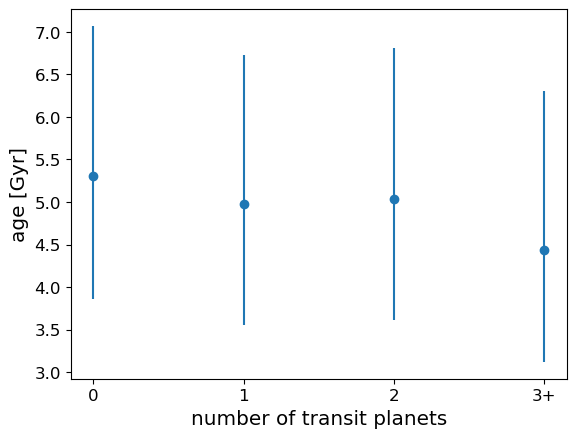

In [100]:
#plt.errorbar([1], [np.median(ones.iso_age)], yerr=[[-np.median(ones.iso_age_err2)], [np.median(ones.iso_age_err1)]], fmt='o')
plt.errorbar(yang_comparison.multi, yang_comparison.age, yerr=[yang_comparison.err2, yang_comparison.err1],
            fmt='o')

plt.ylabel('age [Gyr]')
plt.xlabel('number of transit planets')
plt.show()

Hmm, our "trend" with isochrone ages is way not obvious, unlike Yang+'s.